Answer to weekly check-in:

One of the ideas we discussed in class was the idea that you could calculate the rates of barrier crossing since they are proportional to the barrier height. Although we mostly talked about it in the context of protein folding, I think we could relate it to this ligand binding paper since free energy relates both to ligand binding and protein folding as it provides both information about what the most favorable state is as well as the most likely path to that state (i.e. the one with the lowest free energy barriers and the fastest rates).

One further analysis that we could perhaps do is to plot some free energy plots for this ligand binding like we've been doing recently and calculate some barrier heights based off of those. Perhaps, if we do these free-energy analyses over all of the simulations they run, we could figure out some useful generalized information about rates of ligand binding and ligands moving to different locations on the src kinase protein. If we compare several ligands more ligands in addition to dasatnib and PP1, we might see which are better at moving away from certain local energy minima towards the native binding pose. Perhaps, we could also calculate the energy barrier(s) between the allosteric binding sites and the actual native binding pose or other local energy minima. That way we could decide whether binding to those allosteric binding sites will actually be problematic for the ligands of interest or if the rates of them leaving those allosteric binding sites will be fast enough on the human time scale that these ligands. Perhaps, we won't even need to run longer simulations like I've been talking about these previous few weeks and instead just use these energy barriers. (The power of new analyses!)

Another idea that we dicussed in class was the idea of protein transition states and chi values, where if you mutate a residue and calculate the chi-value afterwards, you can tell whether this residue is involved in the transition state/intermediate. If the chi-value is 1, then your residue is involved in the transition state vecause such changes have destabilized the transition state. If it's 0, then your residue is not, and there is no destabilization. In the Shan et al. paper, they found that a molecular water shell (that lasted around 0.1 microsecond) was involved in the intermediate state immediately before binding in their simulation. I'm wondering if it would be possible to see how involved the water shell actually in the transition state between the bound and unbound states by somehow calculating chi values. I am not sure how we could "mutate" the water molecules, but perhaps we could come up with a way to prevent them from forming the shell during the transition state and then calulating the chi-values. Perhaps running this sort of new simulation could allow us to discern how involved that water shell is actually involved in the transition state.

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import math
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
                  array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import seaborn as sns
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import sklearn
from sklearn.decomposition import PCA
import itertools
import mdtraj as md


This is a 125 microsecond trajectory of fast folding variant of the Villin Headpiece generated from DEShaw Research:

https://www.science.org/doi/full/10.1126/science.1208351

It can be compared to an X-ray structure:
https://www.rcsb.org/structure/2F4K
(Note that the x-ray structure has multiple positions for some sidechain atoms)

You can download the required files here:
https://www.dropbox.com/s/60jxmiuvlyehbhz/Villin_Lab.zip?dl=0

In [2]:
pdb='C:/Users/leman/Documents/CHEM101.6-96.6/Lab2_ProteinMD/Villin_Lab/2F4K.protein.pdb'
trajectory='C:/Users/leman/Documents/CHEM101.6-96.6/Lab2_ProteinMD/Villin_Lab/2F4K.protein.s10.dcd'
xray_CA_pdb='C:/Users/leman/Documents/CHEM101.6-96.6/Lab2_ProteinMD/Villin_Lab/2f4K.xray.CA.pdb'
outdir='C:/Users/leman/Documents/CHEM101.6-96.6/Lab2_ProteinMD/Villin_Lab/output'
if not os.path.exists('outdir'):
    os.makedirs('outdir')
    
print("outdir:",outdir)
print("pdb:",pdb)
print("trjaectory:",trajectory)

outdir: C:/Users/leman/Documents/CHEM101.6-96.6/Lab2_ProteinMD/Villin_Lab/output
pdb: C:/Users/leman/Documents/CHEM101.6-96.6/Lab2_ProteinMD/Villin_Lab/2F4K.protein.pdb
trjaectory: C:/Users/leman/Documents/CHEM101.6-96.6/Lab2_ProteinMD/Villin_Lab/2F4K.protein.s10.dcd


In [3]:
stride_sel=5
trj = md.load(trajectory, top=pdb,stride=stride_sel)
trj.center_coordinates()
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames=trj.n_frames
trj_length=125
time=np.linspace(0,125,n_frames)

In [4]:
nres=[]
for res in trj.topology.residues: nres.append(res.resSeq)
sequence=(' %s' % [residue for residue in trj.topology.residues])
resname=(' %s' % [residue.name for residue in trj.topology.residues])
resindex=(' %s' % [residue.index for residue in trj.topology.residues])
res_num=(' %s' % [residue.resSeq  for residue in trj.topology.residues])



#log = open("/Users/paulrobustelli/Desktop/Sa_calc.log", "w")
print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue number: %s\n" % res_num)
print("residue index: %s\n" % resindex)


** SYSTEM INFO **

Number of atoms: 577

Number of residues: 35

Number of frames: 12559

Starting frame: 0

Last frame: 12559

sequence:  [LEU42, SER43, ASP44, GLU45, ASP46, PHE47, LYS48, ALA49, VAL50, PHE51, GLY52, MET53, THR54, ARG55, SER56, ALA57, PHE58, ALA59, ASN60, LEU61, PRO62, LEU63, TRP64, NLE65, GLN66, GLN67, HIS68, LEU69, NLE70, LYS71, GLU72, LYS73, GLY74, LEU75, PHE76, LEU42, SER43, ASP44, GLU45, ASP46, PHE47, LYS48, ALA49, VAL50, PHE51, GLY52, MET53, THR54, ARG55, SER56, ALA57, PHE58, ALA59, ASN60, LEU61, PRO62, LEU63, TRP64, NLE65, GLN66, GLN67, HIS68, LEU69, NLE70, LYS71, GLU72, LYS73, GLY74, LEU75, PHE76]

residue names:  ['LEU', 'SER', 'ASP', 'GLU', 'ASP', 'PHE', 'LYS', 'ALA', 'VAL', 'PHE', 'GLY', 'MET', 'THR', 'ARG', 'SER', 'ALA', 'PHE', 'ALA', 'ASN', 'LEU', 'PRO', 'LEU', 'TRP', 'NLE', 'GLN', 'GLN', 'HIS', 'LEU', 'NLE', 'LYS', 'GLU', 'LYS', 'GLY', 'LEU', 'PHE', 'LEU', 'SER', 'ASP', 'GLU', 'ASP', 'PHE', 'LYS', 'ALA', 'VAL', 'PHE', 'GLY', 'MET', 'THR', 'ARG', 'SER', 'A

In [5]:
residue_num=[]
for res in top.residues: 
    residue_num.append(res.resSeq)
residue_id=np.asarray(residue_num)


In [6]:
xray_CA = md.load_pdb(xray_CA_pdb)
top_xray = xray_CA.topology
top_xray
residue_xray=[]
for res in top_xray.residues: 
    residue_xray.append(res.resSeq)
resid_xray=np.asarray(residue_xray)
resid_xray

array([42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
       59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,
       76])

In [7]:
#Use DSSP to calculate the secondary structure definition
#https://mdtraj.org/1.9.4/api/generated/mdtraj.compute_dssp.html
trjBB = md.load(trajectory, top=pdb,stride=stride_sel)
BB=top.select("backbone")
trjBB.restrict_atoms(BB)
trjBB.center_coordinates()

dssp=md.compute_dssp(trjBB,simplified=True)


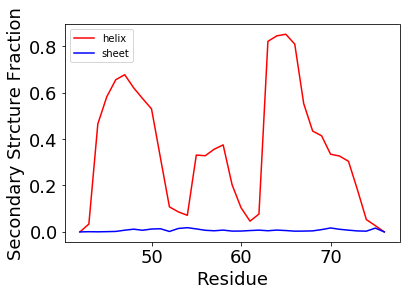

In [8]:
#dssp=md.compute_dssp(trj,simplified=True)

def dssp_convert(dssp):
 dsspH=np.copy(dssp)
 dsspE=np.copy(dssp)
 dsspH[dsspH=='H']=1                                                                                      
 dsspH[dsspH=='E']=0                                                                                      
 dsspH[dsspH=='C']=0                                                                                      
 dsspH[dsspH=='NA']=0 
 dsspH=dsspH.astype(int)
 TotalH=np.sum(dsspH,axis=1) 
 Hprop=np.sum(dsspH,axis=0).astype(float)/len(dsspE) 

 dsspE[dsspE=='H']=0
 dsspE[dsspE=='E']=1
 dsspE[dsspE=='C']=0
 dsspE[dsspE=='NA']=0
 dsspE=dsspE.astype(int)
 TotalE=np.sum(dsspE,axis=1) 
 Eprop=np.sum(dsspE,axis=0).astype(float)/len(dsspE) 
 return Hprop, Eprop

Hprop,Eprop=dssp_convert(dssp)
plt.plot(resid_xray,Hprop,c='r',label='helix')
plt.plot(resid_xray,Eprop,c='b',label='sheet')

plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)


In [9]:
indices_phi, phis = md.compute_phi(trj)
indices_psi, psis = md.compute_psi(trj)
indices_chi1, chi1s = md.compute_chi1(trj)
indices_chi2, chi2s = md.compute_chi2(trj)

In [10]:
phi_dict={}
dihedral_dict = { 'phi': { },
          'psi': { },
          'chi1': { },
          'chi2': { }}

for i in range(0,len(indices_phi)):
  indices=indices_phi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['phi'][resnum]=phis[:,i]

for i in range(0,len(indices_psi)):
  indices=indices_psi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['psi'][resnum]=psis[:,i]

for i in range(0,len(indices_chi1)):
  indices=indices_chi1[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi1'][resnum]=chi1s[:,i]

for i in range(0,len(indices_chi2)):
  indices=indices_chi2[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi2'][resnum]=chi2s[:,i]

In [11]:
#Heres a function to plot a phi/psi ramachandran plot:

def plot_phipsi(res):
 plt.hist2d(dihedral_dict['phi'][res],dihedral_dict['psi'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
 plt.xlabel('$\phi$', size=18)
 plt.ylabel('$\psi$', size=18)
 plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.tick_params(labelsize=18)
 plt.show()
 return

def plot_chi(res):
    if res in dihedral_dict['chi1']:
     plt.hist(dihedral_dict['chi1'][res],bins=36,range=[-3.14,3.14])        
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('counts', size=18)
     plt.tick_params(labelsize=18)
     plt.show()
     plt.clf()   
    if res in dihedral_dict['chi2']:
     plt.hist2d(dihedral_dict['chi1'][res],dihedral_dict['chi2'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('$\chi_2$', size=18)
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.tick_params(labelsize=18)
     plt.show()
    return




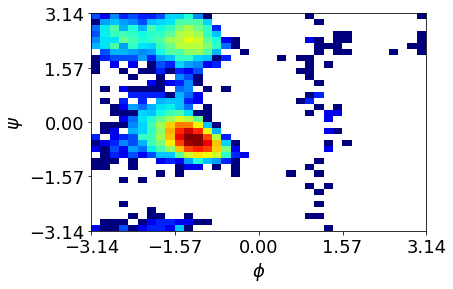

In [12]:
plot_phipsi(45)


C:\Users\leman\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


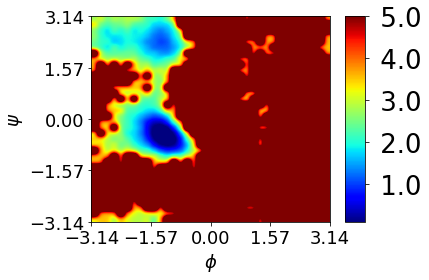

In [13]:
def plot_phipsi_FES(res):
 free_energy,xedges,yedges=np.histogram2d(dihedral_dict['psi'][res],dihedral_dict['phi'][res],36,[[-3.14,3.14],[-3.14,3.14]],normed=True,weights=None)
 free_energy=np.log(np.flipud(free_energy)+.000001)
 T=300                                                                                                  
 kbT=T*0.008314/4.184 # kT in kcal/mol
 dG=-(kbT)*free_energy #Convert to kcal/mol
 im=plt.imshow(dG, interpolation='gaussian',extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],cmap='jet',aspect='auto')
 cbar_ticks=[0,1,2,3,4,5]
 cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'), aspect=10) # grab the Colorbar instance
 imaxes = plt.gca()                                                                                                 
 plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.xlabel('$\phi$', size=18)
 plt.ylabel('$\psi$', size=18)
 plt.tick_params(labelsize=18)
 plt.axes(cb.ax)
 plt.clim(vmin=0.1,vmax=5.0)
 plt.yticks(size='26')
 plt.tight_layout()
 plt.show()
 return

plot_phipsi_FES(45)

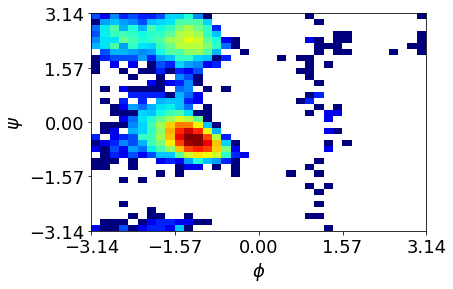

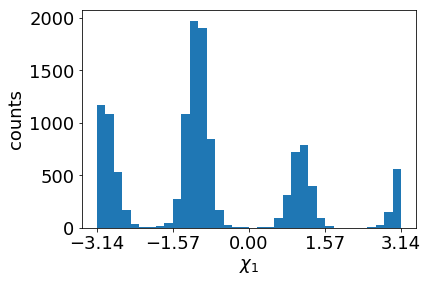

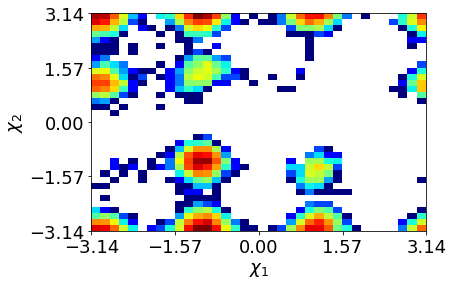

In [14]:
plot_phipsi(45)
plt.clf()
plot_chi(45)

In [15]:
xray_CA = md.load_pdb(xray_CA_pdb)
top_xray = xray_CA.topology
top_xray
residue_xray=[]
for res in top.residues: 
    residue_xray.append(res.resSeq)
resid_xray=np.asarray(residue_xray)
resid_xray

array([42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
       59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,
       76, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
       58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74,
       75, 76])

In [16]:
trjCA = md.load(trajectory, top=pdb,stride=stride_sel)
CA=top.select("name CA")
trjCA.restrict_atoms(CA)
trjCA.center_coordinates()

<mdtraj.Trajectory with 12559 frames, 35 atoms, 35 residues, and unitcells at 0x22ae98dc630>

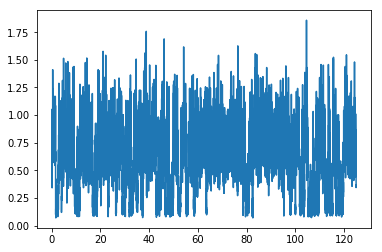

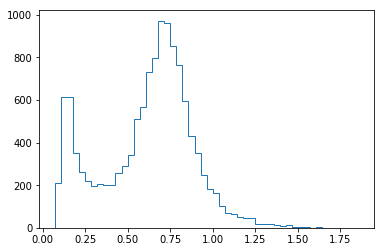

In [17]:
#CA_trj_sel=trj.topology.select("name CA")
#CA_xray_sel=xray_CA.topology.select("name CA")
rmsd = md.rmsd(trjCA,xray_CA)
plt.plot(time,rmsd)
plt.show()
plt.clf()

plt.hist(rmsd,histtype='step',bins=50)
plt.show()

In [18]:
native_frames=np.where(rmsd<0.25)[0]
len(native_frames)
trj[native_frames].save_dcd(outdir+'native.dcd')

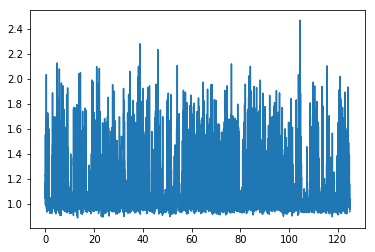

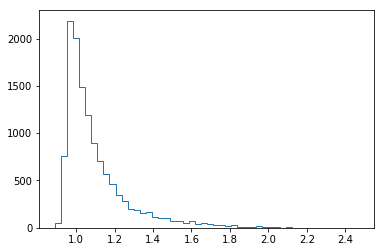

In [19]:
#Lets calculate the radius of gyration
rg=md.compute_rg(trj, masses=None)
plt.plot(time,rg)
plt.show()
plt.clf()

plt.hist(rg,histtype='step',bins=50)
plt.show()

In [20]:
import sklearn
from sklearn.decomposition import PCA

pca1 = PCA(n_components=2)
trj.superpose(trj, 0)
reduced_cartesian = pca1.fit_transform(trj.xyz.reshape(trj.n_frames, trj.n_atoms * 3))
print(reduced_cartesian.shape)

(12559, 2)


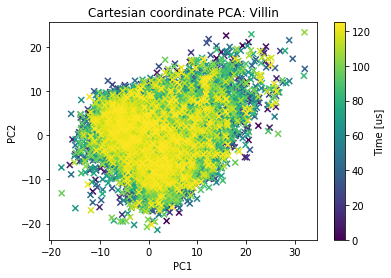

In [21]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=time)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Villin')
cbar = plt.colorbar()
cbar.set_label('Time [us]')

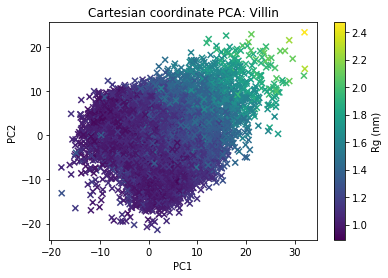

In [22]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=rg)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Villin')
cbar = plt.colorbar()
cbar.set_label('Rg (nm)')

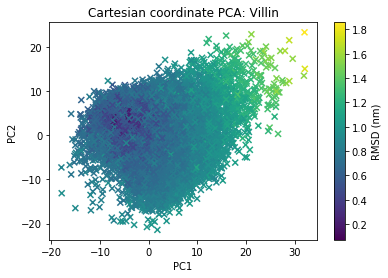

In [23]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=rmsd)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Villin')
cbar = plt.colorbar()
cbar.set_label('RMSD (nm)')

C:\Users\leman\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


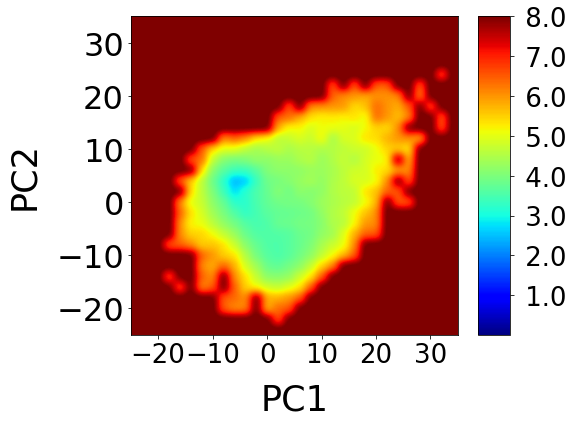

In [24]:
def free_energy(a, b, T, y0, ymax, x0, xmax):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], normed=True, weights=None)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges

PC1=reduced_cartesian[:, 0]
PC2=reduced_cartesian[:,1]

dG,xedges,yedges=free_energy(PC2, PC1, 300, -25, 35, -25, 35)

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5,6,7,8]
plt.xlim(-25,35)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("PC2", size=35, labelpad=15)
plt.xlabel("PC1", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=8.0)
plt.yticks(size='26')
plt.tight_layout()

*** Classroom Activitiy: Lets plot the free energy as a function of RMSD***

In [25]:
#Lets Plot Free Energies as a function of RMSD and Rg

def free_energy1D(a,T,x0,xmax,bins):
    free_energy, xedges= np.histogram(
        a, bins, [x0, xmax], normed=True, weights=None)
    xcenters= xedges[:-1] + np.diff(xedges)/2
    free_energy = np.log(free_energy+.0000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xcenters

C:\Users\leman\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  """


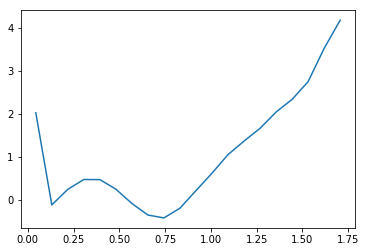

<Figure size 432x288 with 0 Axes>

In [26]:
dG_RMSD,xedges=free_energy1D(rmsd,300,0,1.75,20)

plt.plot(xedges,dG_RMSD)
plt.show()
plt.clf()

C:\Users\leman\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  """


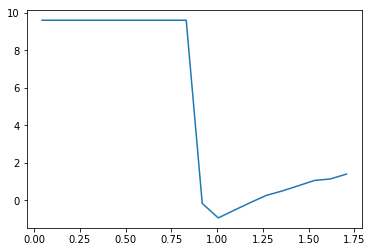

4758
(array([    0,     3,     4, ..., 12552, 12553, 12554], dtype=int64),)


<Figure size 432x288 with 0 Axes>

In [144]:
#Possible HW Prompt:
#Visualize the lowest free energy basin
dG_rg,xedges=free_energy1D(rg,300,0,1.75,20)
plt.plot(xedges,dG_rg)
plt.show()
plt.clf()


basin_frames=np.where((rmsd>0.60) & (rmsd<0.80))
print(len(basin_frames[0]))
print(basin_frames)
trj[basin_frames].save_dcd(outdir+'rmsd.dgmin.basin.dcd')

C:\Users\leman\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


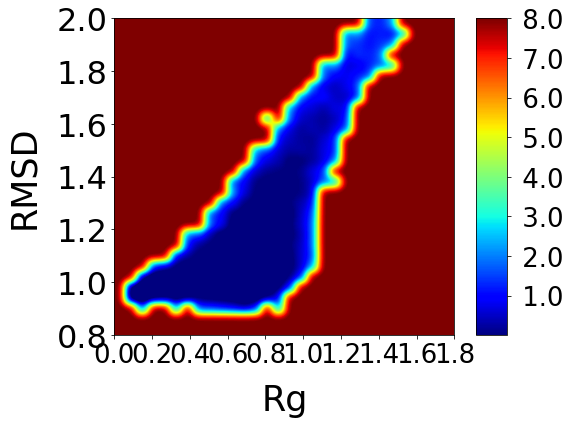

In [28]:
def free_energy(a, b, T, y0, ymax, x0, xmax):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], normed=True, weights=None)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges

dG,xedges,yedges=free_energy(rg, rmsd, 300, 0.8, 2.0, 0, 1.8)

fig = plt.figure(figsize=(8, 6))
#im = plt.imshow(dG, extent=[
#                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5,6,7,8]
#plt.xlim(-25,35)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("RMSD", size=35, labelpad=15)
plt.xlabel("Rg", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=8.0)
plt.yticks(size='26')
plt.tight_layout()

In [29]:
#Lets Make a Contact Map
contact_maps = []
contact_distances = []

for i in range(0, 34):
    contact_map = []
    contact_distance = []
    for j in range(0, 34):
        if i == j:
            contacts = 0
        else:
            dist = md.compute_contacts(trj, [[i, j]])
            array = np.asarray(dist[0]).astype(float)
            distance = np.average(array)
            contact_distance.append(distance)
            contact = np.where(array < 0.5, 1, 0)
            contacts = np.average(contact)
        contact_map.append(contacts)
    contact_maps.append(contact_map)
    contact_distances.append(contact_distance)
final_map = np.asarray(contact_maps).astype(float)
final_distance = np.asarray(contact_distances).astype(float)


In [30]:
#Lets Make Nice Contact Map Labels; get res names and put them into here
sequence=[]
for residue in trj.topology.residues:
    sequence.append(residue)

#Lets Zero Out some of the Labels; save every other res
n=2
for i in range (0,len(sequence)): 
  if (i % n !=0):
   sequence[i]=''

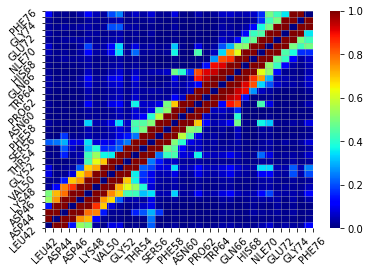

In [31]:
ax = sns.heatmap(final_map, vmin=0.0, vmax=1.0,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,35))
ax.set_yticks(range(0,35))
ax.set_xticklabels(sequence[:35],rotation=45)
ax.set_yticklabels(sequence[:35],rotation=45)
plt.show()

In [32]:
#Lets Make a Contact Map of the low ebergt basin
contact_maps = []
contact_distances = []

for i in range(0, 34):
    contact_map = []
    contact_distance = []
    for j in range(0, 34):
        if i == j:
            contacts = 0
        else:
            dist = md.compute_contacts(trj[native_frames], [[i, j]])
            array = np.asarray(dist[0]).astype(float)
            distance = np.average(array)
            contact_distance.append(distance)
            contact = np.where(array < 0.5, 1, 0)
            contacts = np.average(contact)
        contact_map.append(contacts)
    contact_maps.append(contact_map)
    contact_distances.append(contact_distance)
final_map = np.asarray(contact_maps).astype(float)
final_distance = np.asarray(contact_distances).astype(float)

In [33]:
#Lets Make Nice Contact Map Labels; get res names and put them into here
sequence=[]
for residue in trj.topology.residues:
    sequence.append(residue)

#Lets Zero Out some of the Labels; save every other res
n=2
for i in range (0,len(sequence)): 
  if (i % n !=0):
   sequence[i]=''

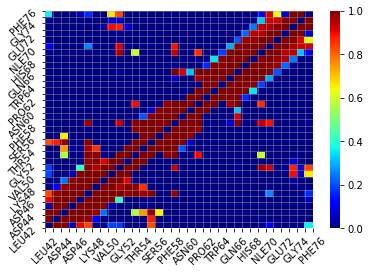

In [34]:
ax = sns.heatmap(final_map, vmin=0.0, vmax=1.0,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,35))
ax.set_yticks(range(0,35))
ax.set_xticklabels(sequence[:35],rotation=45)
ax.set_yticklabels(sequence[:35],rotation=45)
plt.show()
#Seems to be nonspecific collapsed state

In [35]:
def circular_mean(angle):
    return np.arctan2(np.sum(np.sin(angle)),np.sum(np.cos(angle)))


def circular_corr(angle1,angle2):
    cmean1=circular_mean(angle1)
    cmean2=circular_mean(angle2)
    numerator=(np.sum(np.sin(angle1-cmean1)*np.sin(angle2-cmean2)))
    denom=((np.sum(np.sin(angle1-cmean1)**2)*np.sum(np.sin(angle2-cmean2)**2))**.5)
    ccor=numerator/denom
    return ccor

In [36]:
# Make correlation contact map
correlation_maps = []
for i in range(43, 76):
    cor_map = []
    for j in range(43, 76):
        phi=dihedral_dict['phi'][i]
        psi=dihedral_dict['psi'][j]
        ccor=circular_corr(psi,phi)
        cor_map.append(ccor)
    correlation_maps.append(cor_map)
final_cor_map = np.asarray(correlation_maps).astype(float)
np.shape(final_map)

(34, 34)

In [37]:
sequence=[]
for residue in trj.topology.residues:
    sequence.append(residue)
len(sequence)
seq_trunc=sequence[1:34]
#Lets Zero Out some of the Labels 
n=2
for i in range (0,33): 
  if (i % n !=0):
   seq_trunc[i]=''

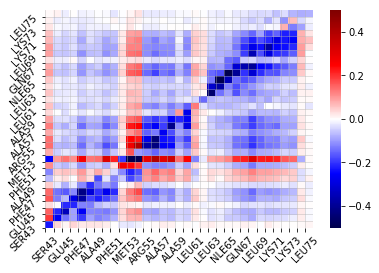

In [38]:
mask = np.zeros_like(final_map)
zeros=np.where((final_map<0.10) & (final_map>-0.10))
mask[zeros] = True
ax = sns.heatmap(final_cor_map, vmin=-0.5, vmax=0.5,cmap='seismic')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,33))
ax.set_yticks(range(0,33))
ax.set_xticklabels(seq_trunc,rotation=45)
ax.set_yticklabels(seq_trunc,rotation=45)
plt.show()

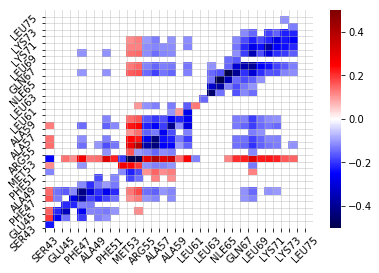

In [39]:
mask = np.zeros_like(final_cor_map)
zeros=np.where((final_cor_map<0.10) & (final_cor_map>-0.10))
mask[zeros] = True
ax = sns.heatmap(final_cor_map,mask=mask, vmin=-0.5, vmax=0.5,cmap='seismic')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,33))
ax.set_yticks(range(0,33))
ax.set_xticklabels(seq_trunc,rotation=45)
ax.set_yticklabels(seq_trunc,rotation=45)
plt.show()

We want to try to Reproduce the Free Energy Plot From
https://www.science.org/doi/full/10.1126/science.1208351

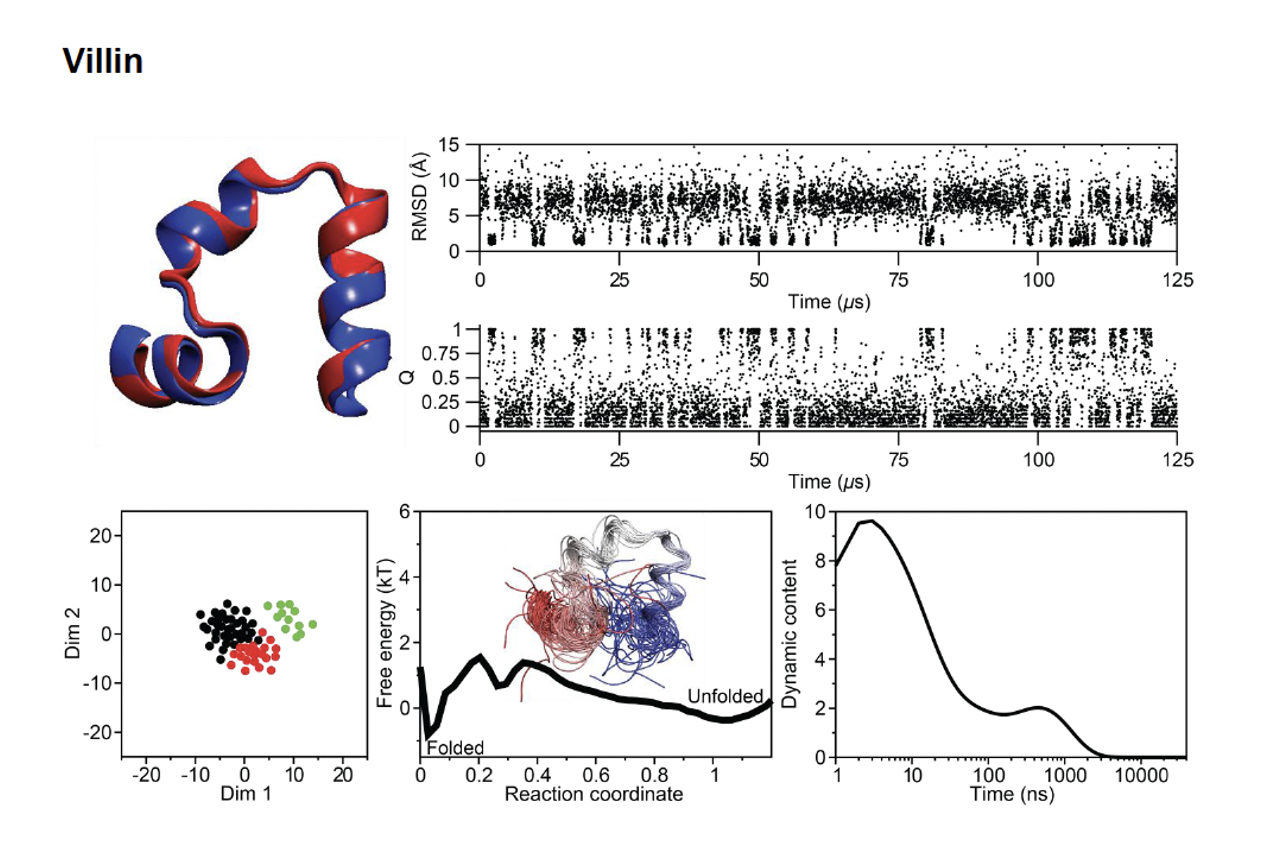

First we need to determine the native contacts and calculate Q

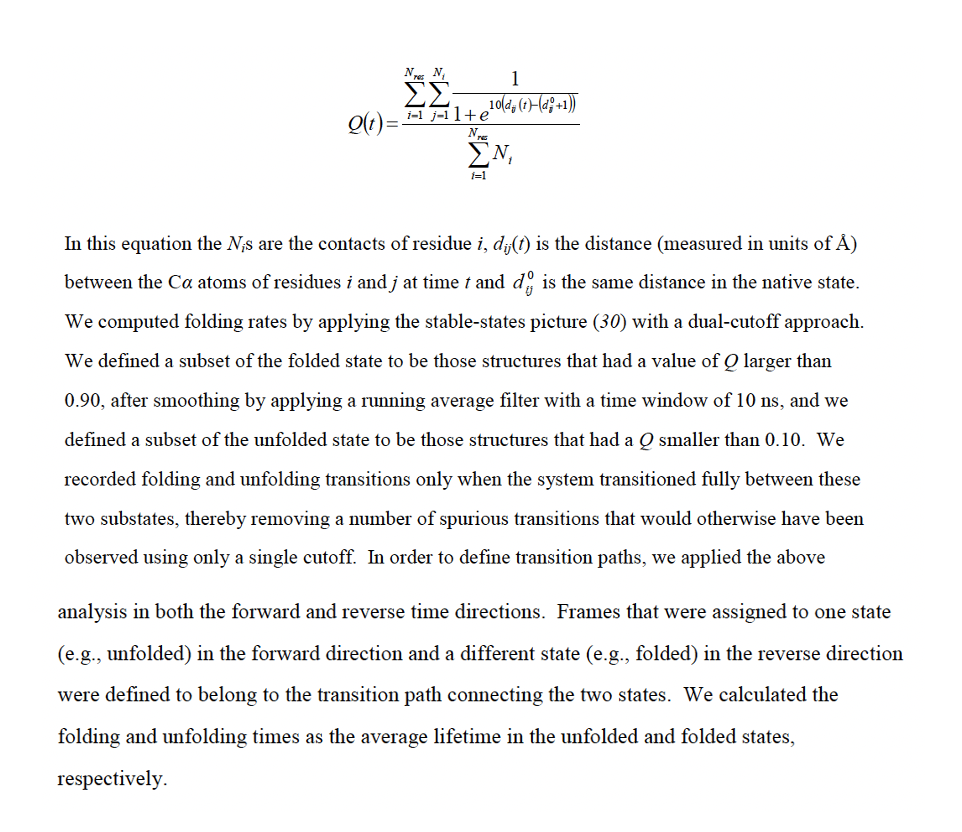

# Question 1 Set Up

(What we did in class.)

In [40]:
#Lets Make a 1D array that contains all native distances pairs:
native_distance_matrix1D = []
for i in range(0, 35):
    for j in range(0, 35):
        if(abs(i-j)>7): # can also append i j pairs if necessary
            dist=md.compute_distances(xray_CA, [[i,j]])[0]
            native_distance_matrix1D.append(dist[0])
        
native_distance_matrix1D
#Conv to ang
native_distance_matrix1D=np.asarray(native_distance_matrix1D)*10

In [174]:
#native_distance_matrix1D

In [42]:
#Lets Make a 1D array that contains all native distances pairs:
native_distance_matrix1D = []
for i in range(0, 35):
    for j in range(0, 35):
        if(abs(i-j)>7):
            dist=md.compute_distances(xray_CA, [[i,j]])[0]
            native_distance_matrix1D.append(dist[0])
        
native_distance_matrix1D
#Conv to ang

#QUESTION: How can you make a 1D Array that only contains distances between residue pairs seperated by more than 7 residuyes



#Convert to Angstrom
native_distance_matrix1D=np.asarray(native_distance_matrix1D)*10


In [43]:
#Now lets do the same thing for our trajectory, making an array that is contacts vs. #frames in the trajectory

traj_CA_distance_matrix1D=[]

for i in range(0, 35):
    for j in range(0, 35):
        if(abs(i-j)>7):
            dist=md.compute_distances(trjCA, [[i,j]])[:,0]
            traj_CA_distance_matrix1D.append(dist)

#Convert to Angstrom
traj_CA_distance_matrix1D=np.asarray(traj_CA_distance_matrix1D)*10

print(traj_CA_distance_matrix1D)    
print(np.shape(traj_CA_distance_matrix1D))

[[16.155031  14.692731  10.791452  ... 13.44309   11.834915  12.631355 ]
 [14.991053  16.75532   10.736588  ... 15.2884655 13.566652  13.6923685]
 [12.063679  18.618668  12.658627  ... 16.286385  14.426516  15.135903 ]
 ...
 [19.731848  15.481565  18.494164  ... 15.782475   8.443002  14.883488 ]
 [17.971453  15.527249  18.071562  ... 15.393051   8.662318  14.951433 ]
 [15.186663  12.335569  14.823526  ... 11.786729   5.1311684 11.634714 ]]
(756, 12559)


In [44]:
native_frames

array([  158,   159,   160, ..., 12022, 12023, 12027], dtype=int64)

In [175]:
#Make Sure that For each Distance you can compare that native distance to the trajectory distance 
np.shape(traj_CA_distance_matrix1D[:,native_frames])
#Distances For All CA-CA pairs in the native frames
traj_CA_distance_matrix1D[:,native_frames]
native_average=np.average(traj_CA_distance_matrix1D[:,native_frames],axis=1)
print(np.shape(native_average))
#print(native_average)

(756,)


In [46]:
Native_Contact_Indices=np.where(native_average<10.0)[0]#Less than 10 ang in native state
len(Native_Contact_Indices)
print(Native_Contact_Indices)

[  5  30  31  54  55  56  57  78  79  80 102 103 125 128 201 204 206 220
 221 224 250 251 269 270 271 272 288 289 290 291 292 293 310 353 357 360
 524 546 547 577 584 596 597 662 663 711 728 754]


In [47]:
Native_Contacts_Trj_Dist=traj_CA_distance_matrix1D[Native_Contact_Indices]
print(np.shape(Native_Contacts_Trj_Dist))

Native_Contacts_Xray_Dist=native_distance_matrix1D[Native_Contact_Indices]
print(Native_Contacts_Xray_Dist)

(48, 12559)
[ 9.985726  10.452459   9.704253   9.60349    7.0967283  7.0852814
  9.99271    9.574567   8.303897   9.653462   9.633482  10.225195
  6.8318415  9.7255125  9.797035   7.3131294  9.571478   7.4795647
  8.667388   7.7988334  9.60349    9.574567  10.452459   7.0967283
  8.303897   9.633482   9.985726   9.704253   7.0852814  9.653462
 10.225195   6.8318415  9.99271    9.7255125  6.6416473  9.298402
  6.6416473  9.69183    9.276201   7.4795647  9.298402   9.797035
  8.667388   7.3131294  7.7988334  9.571478   9.69183    9.276201 ]


In [48]:
for i in range(0,48):
    print(Native_Contacts_Xray_Dist[i],Native_Contacts_Trj_Dist[i])

9.985726 [11.540491 15.242111 20.317595 ... 11.133914  9.802909  9.529006]
10.452459 [ 9.374432 15.550833 18.456451 ...  9.84092   8.556069  8.788097]
9.704253 [11.477718 13.614361 20.877588 ...  8.659006  7.637048  7.693935]
9.60349 [ 9.620813  14.315687  13.511494  ...  9.546892   7.7607603  7.720747 ]
7.0967283 [ 8.358078  12.062386  16.181501  ...  6.1711082  5.2470694  5.1262226]
7.0852814 [10.051856  10.599729  18.739012  ...  5.1992693  5.975244   5.3546863]
9.99271 [13.804028 13.680305 21.581156 ...  7.900141  8.840288  8.60963 ]
9.574567 [12.595353  16.094152  12.5168705 ...  8.90573    9.433759   9.204168 ]
8.303897 [11.918608 14.237659 15.800192 ...  6.660173  8.140754  7.861574]
9.653462 [13.711605  13.591568  17.694164  ...  7.4799404  9.589137   8.898192 ]
9.633482 [12.349012 15.875407 14.908751 ...  8.254533  8.746978  8.578752]
10.225195 [14.985344 15.004972 16.675589 ...  8.071144  9.364284  8.658443]
6.8318415 [12.484558  12.280922  14.192814  ...  5.4976153  6.584661

In [49]:
#Expand Native Distance Matrix so that its the same number of frames as the trajectory

Xray_Distance_Expand=np.zeros(np.shape(Native_Contacts_Trj_Dist))
for i in range(0,len(Native_Contacts_Trj_Dist)):
    Xray_Distance_Expand[i,:]=Native_Contacts_Xray_Dist[i]
    
print(Xray_Distance_Expand)
print(np.shape(Xray_Distance_Expand))

[[ 9.98572636  9.98572636  9.98572636 ...  9.98572636  9.98572636
   9.98572636]
 [10.45245934 10.45245934 10.45245934 ... 10.45245934 10.45245934
  10.45245934]
 [ 9.7042532   9.7042532   9.7042532  ...  9.7042532   9.7042532
   9.7042532 ]
 ...
 [ 9.57147789  9.57147789  9.57147789 ...  9.57147789  9.57147789
   9.57147789]
 [ 9.69182968  9.69182968  9.69182968 ...  9.69182968  9.69182968
   9.69182968]
 [ 9.27620125  9.27620125  9.27620125 ...  9.27620125  9.27620125
   9.27620125]]
(48, 12559)


# Question 1 Answer

Min Q: 1.2915567930939182e-05
Max Q: 0.888347941003218


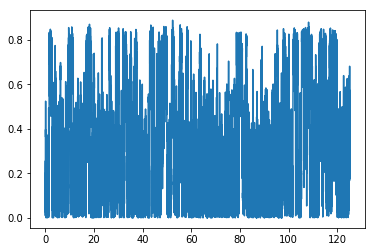

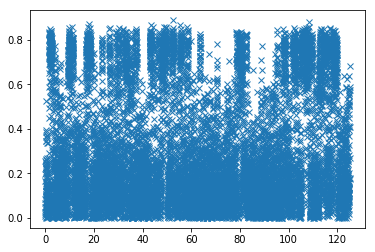

<Figure size 432x288 with 0 Axes>

In [142]:
#Write a function to Calculate Q
import math
#Don't need to multiply by 10 since we already converted to angstroms previously.
exponential_array = np.exp(Native_Contacts_Trj_Dist-(Xray_Distance_Expand+1))
#print(exponential_array)

def calc_Q(frame):
    num_sum = 0
    for exponential in range(0,len(exponential_array)):
        num_sum += 1/(1+exponential_array[exponential][frame])
    return num_sum/len(Native_Contact_Indices)

    


#print(n_frames)    

#print(calc_Q(1))

Q=[]
Qmin=0.5
Qmax=0.5
for frame in range(0,n_frames):
    currQ = calc_Q(frame)
    if(currQ<Qmin):
        Qmin = currQ
    if(currQ>Qmax):
        Qmax = currQ
    Q.append(currQ)

#Find the lowest and the highest so we can make some nice free energy plots later on.
print("Min Q:",Qmin)
print("Max Q:",Qmax)
plt.plot(time,Q)
plt.show()
plt.clf()
plt.plot(time,Q,marker='x',linewidth=.005)
plt.show()
plt.clf()

# Question 2

[1.23435826 1.5553001  1.2904328  ... 0.94887611 0.93968678 0.93831308]


C:\Users\leman\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


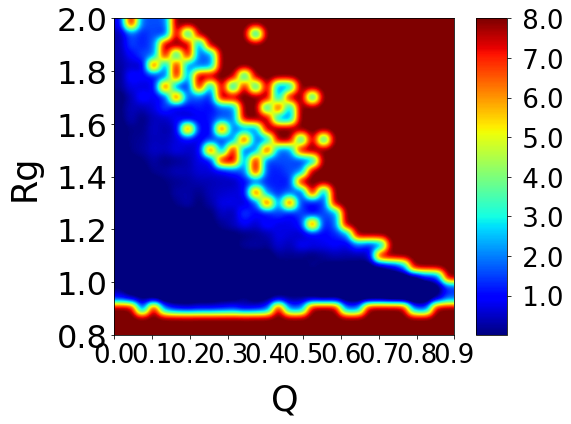

C:\Users\leman\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


[0.62181437 1.0520786  0.8402181  ... 0.34461957 0.3480509  0.36810905]


<Figure size 432x288 with 0 Axes>

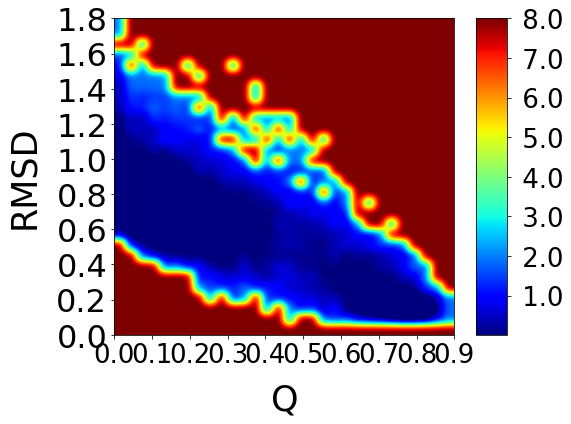

[0.         0.01778496 0.70735651 0.82215036 0.88278092 0.93047696
 0.90945837 0.86014551 0.81972514 0.39531124 0.0113177  0.00646726
 0.00485044 0.76313662 0.78172999 0.8156831  0.80355699 0.35327405
 0.1083266  0.         0.0105093  0.92239289 0.93856103 0.94745352
 0.93613581 0.85125303 0.7712207  0.75990299 0.56103476 0.51010509
 0.44866613 0.23686338 0.0541633  0.03961196 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


C:\Users\leman\Anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


ValueError: range argument must have one entry per dimension

<Figure size 432x288 with 0 Axes>

In [180]:
#Plot Q and a Histogram

#I already plottted Q above

def free_energy(a, b, T, y0, ymax, x0, xmax):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], normed=True, weights=None)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges

dG,xedges,yedges=free_energy(rg, Q, 300, 0.8, 2.0, 0, 0.9)

print(rg)

fig = plt.figure(figsize=(8, 6))
#im = plt.imshow(dG, extent=[
#                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5,6,7,8]
#plt.xlim(-25,35)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("Rg", size=35, labelpad=15)
plt.xlabel("Q", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=8.0)
plt.yticks(size='26')
plt.tight_layout()
plt.show()
plt.clf()

dG,xedges,yedges=free_energy(rmsd, Q, 300, 0, 1.8, 0, 0.9)

print(rmsd)

fig = plt.figure(figsize=(8, 6))
#im = plt.imshow(dG, extent=[
#                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5,6,7,8]
#plt.xlim(-25,35)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("RMSD", size=35, labelpad=15)
plt.xlabel("Q", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=8.0)
plt.yticks(size='26')
plt.tight_layout()
plt.show()
plt.clf()

#Not sure what's going on here, but Python seems to get mad when I attempt
#to plot against Hprop
print(Hprop)

dG,xedges,yedges=free_energy(Hprop, Q, 300, 0, 0.9, 0, 0.9)

fig = plt.figure(figsize=(8, 6))
#im = plt.imshow(dG, extent=[
#                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5,6,7,8]
#plt.xlim(-25,35)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("Hprop", size=35, labelpad=15)
plt.xlabel("Q", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=8.0)
plt.yticks(size='26')
plt.tight_layout()
plt.show()
plt.clf()

# Question 3

(I did things a bit differently from what you suggested to calculate the transion paths.)

In [143]:
#Lets Calculate Our Transition Paths using the Dual Cutoff Approach

import collections

folded_thresh = 0.8
unfolded_thresh = 0.2

Q_arr = np.array(Q)

folded = np.where(Q_arr > folded_thresh)
unfolded = np.where(Q_arr < unfolded_thresh)

folded_unfolded_dict = {}

#Generate dictionary of frames and states for those frames.

for i in folded[0]:
    folded_unfolded_dict[i] = 'folded'

for i in unfolded[0]:
    folded_unfolded_dict[i] = 'unfolded'

#Got how to order dictionary from https://stackoverflow.com/questions/9001509/how-can-i-sort-a-dictionary-by-key
    
folded_unfolded_ordered = collections.OrderedDict(sorted(folded_unfolded_dict.items()))

#Essentially, the idea is the same as the dual cutoff approach.
#Because we ordered our dictoionary of frames+folded and unfolded
#states, we can easily find where the protein transitions from one
#state to the other using the function below (dual-cutoff approach). 
#We can also identify what sort of transition state it is.

def id_crossover(dict):
    transitions = []
    prev_key = 0
    prev_state = 'none'
    curr_state = 'none'
    for i in dict:
        curr_state = dict[i]
        if((prev_state == 'folded' and curr_state == 'unfolded') or (prev_state == 'unfolded' and curr_state == 'folded')):
            transitions.append([prev_key, i,curr_state,prev_state])
        prev_key = i
        prev_state = dict[i]
    return transitions

print(id_crossover(folded_unfolded_ordered))

[[155, 159, 'folded', 'unfolded'], [264, 282, 'unfolded', 'folded'], [928, 961, 'folded', 'unfolded'], [1031, 1034, 'unfolded', 'folded'], [1075, 1087, 'folded', 'unfolded'], [1152, 1157, 'unfolded', 'folded'], [1673, 1703, 'folded', 'unfolded'], [1782, 1797, 'unfolded', 'folded'], [1811, 1812, 'folded', 'unfolded'], [1866, 1885, 'unfolded', 'folded'], [2319, 2328, 'folded', 'unfolded'], [2345, 2351, 'unfolded', 'folded'], [2632, 2635, 'folded', 'unfolded'], [2660, 2690, 'unfolded', 'folded'], [2898, 2909, 'folded', 'unfolded'], [2924, 2930, 'unfolded', 'folded'], [2990, 2997, 'folded', 'unfolded'], [3032, 3049, 'unfolded', 'folded'], [3195, 3204, 'folded', 'unfolded'], [3212, 3220, 'unfolded', 'folded'], [3270, 3285, 'folded', 'unfolded'], [3337, 3372, 'unfolded', 'folded'], [3518, 3524, 'folded', 'unfolded'], [3535, 3561, 'unfolded', 'folded'], [3681, 3688, 'folded', 'unfolded'], [3688, 3697, 'unfolded', 'folded'], [3727, 3738, 'folded', 'unfolded'], [3760, 3774, 'unfolded', 'folded'

# Question 5 (question 4 is a suggestion on how to do question 3, which I did differently).

## Contact maps of the three states

In [145]:
#Lets Make a Contact Map of the folded frames
contact_maps = []
contact_distances = []

for i in range(0, 34):
    contact_map = []
    contact_distance = []
    for j in range(0, 34):
        if i == j:
            contacts = 0
        else:
            dist = md.compute_contacts(trj[folded], [[i, j]])
            array = np.asarray(dist[0]).astype(float)
            distance = np.average(array)
            contact_distance.append(distance)
            contact = np.where(array < 0.5, 1, 0)
            contacts = np.average(contact)
        contact_map.append(contacts)
    contact_maps.append(contact_map)
    contact_distances.append(contact_distance)
final_map = np.asarray(contact_maps).astype(float)
final_distance = np.asarray(contact_distances).astype(float)

In [146]:
#Lets Make Nice Contact Map Labels; get res names and put them into here
sequence=[]
for residue in trj.topology.residues:
    sequence.append(residue)

#Lets Zero Out some of the Labels; save every other res
n=2
for i in range (0,len(sequence)): 
  if (i % n !=0):
   sequence[i]=''

folded frames contact map


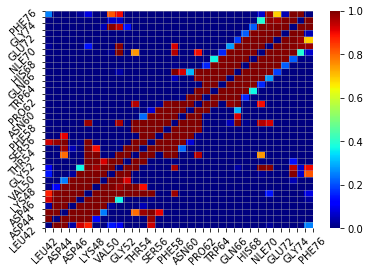

In [147]:
print('folded frames contact map')
ax = sns.heatmap(final_map, vmin=0.0, vmax=1.0,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,35))
ax.set_yticks(range(0,35))
ax.set_xticklabels(sequence[:35],rotation=45)
ax.set_yticklabels(sequence[:35],rotation=45)
plt.show()

In [148]:
#Lets Make a Contact Map of the unfolded frames
contact_maps = []
contact_distances = []

for i in range(0, 34):
    contact_map = []
    contact_distance = []
    for j in range(0, 34):
        if i == j:
            contacts = 0
        else:
            dist = md.compute_contacts(trj[unfolded], [[i, j]])
            array = np.asarray(dist[0]).astype(float)
            distance = np.average(array)
            contact_distance.append(distance)
            contact = np.where(array < 0.5, 1, 0)
            contacts = np.average(contact)
        contact_map.append(contacts)
    contact_maps.append(contact_map)
    contact_distances.append(contact_distance)
final_map = np.asarray(contact_maps).astype(float)
final_distance = np.asarray(contact_distances).astype(float)

In [149]:
#Lets Make Nice Contact Map Labels; get res names and put them into here
sequence=[]
for residue in trj.topology.residues:
    sequence.append(residue)

#Lets Zero Out some of the Labels; save every other res
n=2
for i in range (0,len(sequence)): 
  if (i % n !=0):
   sequence[i]=''

unfolded frames contact map


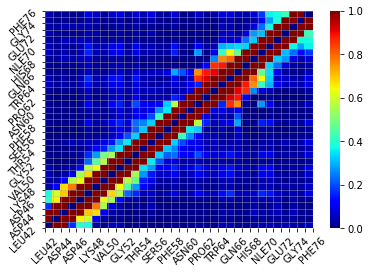

In [150]:
print('unfolded frames contact map')
ax = sns.heatmap(final_map, vmin=0.0, vmax=1.0,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,35))
ax.set_yticks(range(0,35))
ax.set_xticklabels(sequence[:35],rotation=45)
ax.set_yticklabels(sequence[:35],rotation=45)
plt.show()

In [183]:
transitions = id_crossover(folded_unfolded_ordered)

#Essentially, the idea is that between two cutoffs 
#lie all the the transition frames, so we want to
#include those in the transition states' frames.
transition_frames = []
for arr in transitions:
    for frame_num in range(arr[0],arr[1]+1):
        transition_frames.append(frame_num)


In [152]:
#Lets Make a Contact Map of the transition states
contact_maps = []
contact_distances = []

for i in range(0, 34):
    contact_map = []
    contact_distance = []
    for j in range(0, 34):
        if i == j:
            contacts = 0
        else:
            dist = md.compute_contacts(trj[transition_frames], [[i, j]])
            array = np.asarray(dist[0]).astype(float)
            distance = np.average(array)
            contact_distance.append(distance)
            contact = np.where(array < 0.5, 1, 0)
            contacts = np.average(contact)
        contact_map.append(contacts)
    contact_maps.append(contact_map)
    contact_distances.append(contact_distance)
final_map = np.asarray(contact_maps).astype(float)
final_distance = np.asarray(contact_distances).astype(float)

In [153]:
#Lets Make Nice Contact Map Labels; get res names and put them into here
sequence=[]
for residue in trj.topology.residues:
    sequence.append(residue)

#Lets Zero Out some of the Labels; save every other res
n=2
for i in range (0,len(sequence)): 
  if (i % n !=0):
   sequence[i]=''

transition states frames contact map


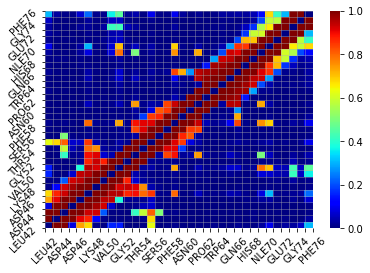

In [154]:
print('transition states frames contact map')
ax = sns.heatmap(final_map, vmin=0.0, vmax=1.0,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,35))
ax.set_yticks(range(0,35))
ax.set_xticklabels(sequence[:35],rotation=45)
ax.set_yticklabels(sequence[:35],rotation=45)
plt.show()

## Correlation maps

In [155]:
# Make correlation contact map for folded frames
correlation_maps = []
for i in range(43, 76):
    cor_map = []
    for j in range(43, 76):
        phi=dihedral_dict['phi'][i][folded]
        psi=dihedral_dict['psi'][j][folded]
        ccor=circular_corr(psi,phi)
        cor_map.append(ccor)
    correlation_maps.append(cor_map)
final_cor_map = np.asarray(correlation_maps).astype(float)
np.shape(final_map)

(34, 34)

In [156]:
sequence=[]
for residue in trj.topology.residues:
    sequence.append(residue)
len(sequence)
seq_trunc=sequence[1:34]
#Lets Zero Out some of the Labels 
n=2
for i in range (0,33): 
  if (i % n !=0):
   seq_trunc[i]=''

folded frames correlation map


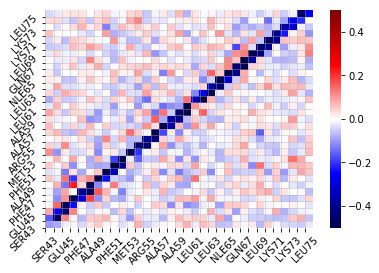

In [157]:
mask = np.zeros_like(final_map)
zeros=np.where((final_map<0.10) & (final_map>-0.10))
mask[zeros] = True
ax = sns.heatmap(final_cor_map, vmin=-0.5, vmax=0.5,cmap='seismic')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,33))
ax.set_yticks(range(0,33))
ax.set_xticklabels(seq_trunc,rotation=45)
ax.set_yticklabels(seq_trunc,rotation=45)
print("folded frames correlation map")
plt.show()

folded frames correlation map


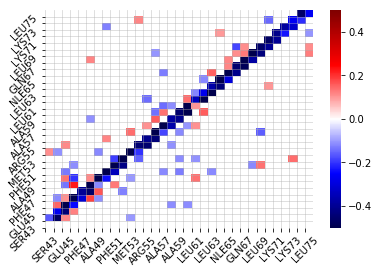

In [158]:
mask = np.zeros_like(final_cor_map)
zeros=np.where((final_cor_map<0.10) & (final_cor_map>-0.10))
mask[zeros] = True
ax = sns.heatmap(final_cor_map,mask=mask, vmin=-0.5, vmax=0.5,cmap='seismic')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,33))
ax.set_yticks(range(0,33))
ax.set_xticklabels(seq_trunc,rotation=45)
ax.set_yticklabels(seq_trunc,rotation=45)
print("folded frames correlation map")
plt.show()

In [159]:
# Make correlation contact map for unfolded frames
correlation_maps = []
for i in range(43, 76):
    cor_map = []
    for j in range(43, 76):
        phi=dihedral_dict['phi'][i][unfolded]
        psi=dihedral_dict['psi'][j][unfolded]
        ccor=circular_corr(psi,phi)
        cor_map.append(ccor)
    correlation_maps.append(cor_map)
final_cor_map = np.asarray(correlation_maps).astype(float)
np.shape(final_map)

(34, 34)

In [160]:
sequence=[]
for residue in trj.topology.residues:
    sequence.append(residue)
len(sequence)
seq_trunc=sequence[1:34]
#Lets Zero Out some of the Labels 
n=2
for i in range (0,33): 
  if (i % n !=0):
   seq_trunc[i]=''

unfolded frames correlation map


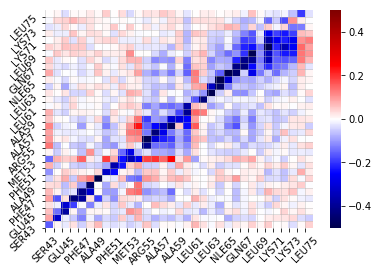

In [181]:
mask = np.zeros_like(final_map)
zeros=np.where((final_map<0.10) & (final_map>-0.10))
mask[zeros] = True
ax = sns.heatmap(final_cor_map, vmin=-0.5, vmax=0.5,cmap='seismic')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,33))
ax.set_yticks(range(0,33))
ax.set_xticklabels(seq_trunc,rotation=45)
ax.set_yticklabels(seq_trunc,rotation=45)
print("unfolded frames correlation map")
plt.show()

unfolded frames correlation map


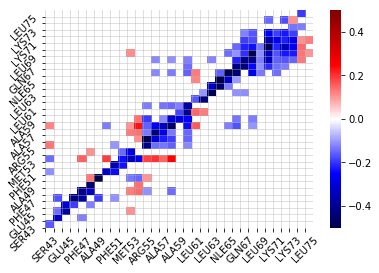

In [182]:
mask = np.zeros_like(final_cor_map)
zeros=np.where((final_cor_map<0.10) & (final_cor_map>-0.10))
mask[zeros] = True
ax = sns.heatmap(final_cor_map,mask=mask, vmin=-0.5, vmax=0.5,cmap='seismic')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,33))
ax.set_yticks(range(0,33))
ax.set_xticklabels(seq_trunc,rotation=45)
ax.set_yticklabels(seq_trunc,rotation=45)
print("unfolded frames correlation map")
plt.show()

In [163]:
# Make correlation contact map for transition frames
correlation_maps = []
for i in range(43, 76):
    cor_map = []
    for j in range(43, 76):
        phi=dihedral_dict['phi'][i][transition_frames]
        psi=dihedral_dict['psi'][j][transition_frames]
        ccor=circular_corr(psi,phi)
        cor_map.append(ccor)
    correlation_maps.append(cor_map)
final_cor_map = np.asarray(correlation_maps).astype(float)
np.shape(final_map)

(34, 34)

In [164]:
sequence=[]
for residue in trj.topology.residues:
    sequence.append(residue)
len(sequence)
seq_trunc=sequence[1:34]
#Lets Zero Out some of the Labels 
n=2
for i in range (0,33): 
  if (i % n !=0):
   seq_trunc[i]=''

transition frames correlation map


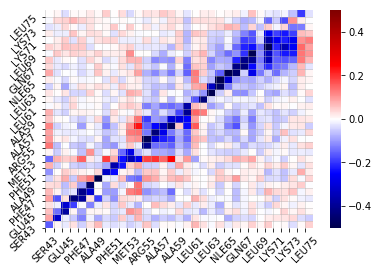

In [165]:
mask = np.zeros_like(final_map)
zeros=np.where((final_map<0.10) & (final_map>-0.10))
mask[zeros] = True
ax = sns.heatmap(final_cor_map, vmin=-0.5, vmax=0.5,cmap='seismic')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,33))
ax.set_yticks(range(0,33))
ax.set_xticklabels(seq_trunc,rotation=45)
ax.set_yticklabels(seq_trunc,rotation=45)
print("transition frames correlation map")
plt.show()

transition frames correlation map


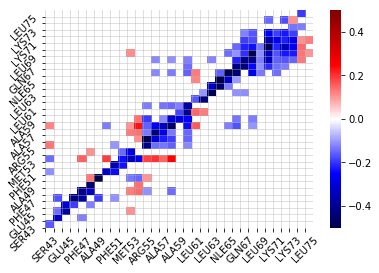

In [166]:
mask = np.zeros_like(final_cor_map)
zeros=np.where((final_cor_map<0.10) & (final_cor_map>-0.10))
mask[zeros] = True
ax = sns.heatmap(final_cor_map,mask=mask, vmin=-0.5, vmax=0.5,cmap='seismic')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,33))
ax.set_yticks(range(0,33))
ax.set_xticklabels(seq_trunc,rotation=45)
ax.set_yticklabels(seq_trunc,rotation=45)
print("transition frames correlation map")
plt.show()

## Secondary structure propensities

Secondary structure propensities for folded frames


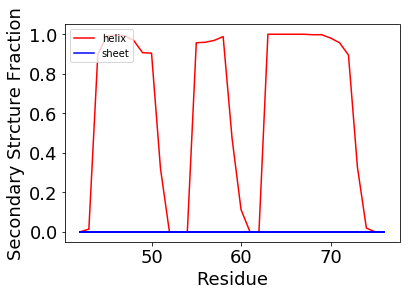

In [167]:
#Secondary structure propensities for folded frames

print("Secondary structure propensities for folded frames")

dssp=md.compute_dssp(trj[folded],simplified=True)

def dssp_convert(dssp):
 dsspH=np.copy(dssp)
 dsspE=np.copy(dssp)
 dsspH[dsspH=='H']=1                                                                                      
 dsspH[dsspH=='E']=0                                                                                      
 dsspH[dsspH=='C']=0                                                                                      
 dsspH[dsspH=='NA']=0 
 dsspH=dsspH.astype(int)
 TotalH=np.sum(dsspH,axis=1) 
 Hprop=np.sum(dsspH,axis=0).astype(float)/len(dsspE) 

 dsspE[dsspE=='H']=0
 dsspE[dsspE=='E']=1
 dsspE[dsspE=='C']=0
 dsspE[dsspE=='NA']=0
 dsspE=dsspE.astype(int)
 TotalE=np.sum(dsspE,axis=1) 
 Eprop=np.sum(dsspE,axis=0).astype(float)/len(dsspE) 
 return Hprop, Eprop

Hprop,Eprop=dssp_convert(dssp)
plt.plot(resid_xray,Hprop,c='r',label='helix')
plt.plot(resid_xray,Eprop,c='b',label='sheet')

plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)


Secondary structure propensities for unfolded frames


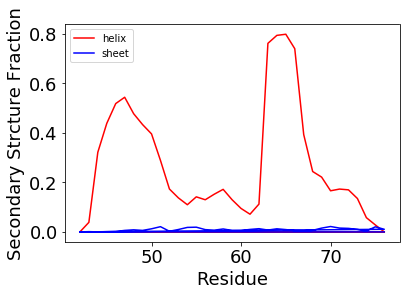

In [168]:
#Secondary structure propensities for unfolded frames

print("Secondary structure propensities for unfolded frames")

dssp=md.compute_dssp(trj[unfolded],simplified=True)

def dssp_convert(dssp):
 dsspH=np.copy(dssp)
 dsspE=np.copy(dssp)
 dsspH[dsspH=='H']=1                                                                                      
 dsspH[dsspH=='E']=0                                                                                      
 dsspH[dsspH=='C']=0                                                                                      
 dsspH[dsspH=='NA']=0 
 dsspH=dsspH.astype(int)
 TotalH=np.sum(dsspH,axis=1) 
 Hprop=np.sum(dsspH,axis=0).astype(float)/len(dsspE) 

 dsspE[dsspE=='H']=0
 dsspE[dsspE=='E']=1
 dsspE[dsspE=='C']=0
 dsspE[dsspE=='NA']=0
 dsspE=dsspE.astype(int)
 TotalE=np.sum(dsspE,axis=1) 
 Eprop=np.sum(dsspE,axis=0).astype(float)/len(dsspE) 
 return Hprop, Eprop

Hprop,Eprop=dssp_convert(dssp)
plt.plot(resid_xray,Hprop,c='r',label='helix')
plt.plot(resid_xray,Eprop,c='b',label='sheet')

plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)


Secondary structure propensities for transition frames


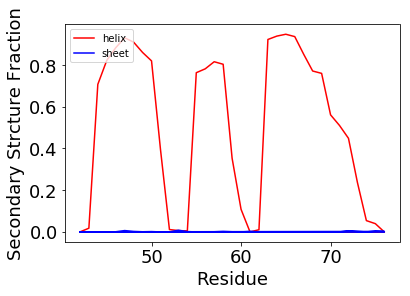

In [173]:
#Secondary structure propensities for transition frames

print("Secondary structure propensities for transition frames")

dssp=md.compute_dssp(trj[transition_frames],simplified=True)

def dssp_convert(dssp):
 dsspH=np.copy(dssp)
 dsspE=np.copy(dssp)
 dsspH[dsspH=='H']=1                                                                                      
 dsspH[dsspH=='E']=0                                                                                      
 dsspH[dsspH=='C']=0                                                                                      
 dsspH[dsspH=='NA']=0 
 dsspH=dsspH.astype(int)
 TotalH=np.sum(dsspH,axis=1) 
 Hprop=np.sum(dsspH,axis=0).astype(float)/len(dsspE) 

 dsspE[dsspE=='H']=0
 dsspE[dsspE=='E']=1
 dsspE[dsspE=='C']=0
 dsspE[dsspE=='NA']=0
 dsspE=dsspE.astype(int)
 TotalE=np.sum(dsspE,axis=1) 
 Eprop=np.sum(dsspE,axis=0).astype(float)/len(dsspE) 
 return Hprop, Eprop

Hprop,Eprop=dssp_convert(dssp)
plt.plot(resid_xray,Hprop,c='r',label='helix')
plt.plot(resid_xray,Eprop,c='b',label='sheet')

plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)


# Question 6

Here, I'm answering the question: what is the average helical propensity in the first and second halves of transition paths?

In [171]:
#Get first and second half of transitions

transitions = id_crossover(folded_unfolded_ordered)
trans_first_half = []
trans_second_half = []
for arr in transitions:
    if(arr[2] == 'folded' and arr[3] == 'unfolded'):
        #print('f',arr)
        for frame_num in range(arr[0],arr[1]+1):
            trans_first_half.append(frame_num)
    elif(arr[2] == 'unfolded' and arr[3] == 'folded'):
        #print('un',arr)
        for frame_num in range(arr[0],arr[1]+1):
            trans_second_half.append(frame_num)
        
#print(trans_first_half)
#print(trans_second_half)

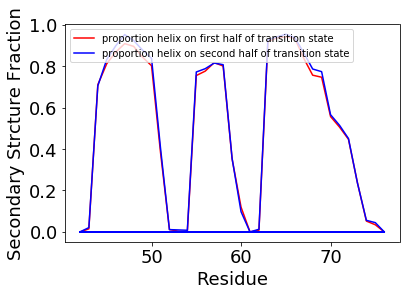

In [172]:
#Helical propensity function
def dsspH_convert(dssp):
 dsspH=np.copy(dssp)
 dsspH[dsspH=='H']=1                                                                                      
 dsspH[dsspH=='E']=0                                                                                      
 dsspH[dsspH=='C']=0                                                                                      
 dsspH[dsspH=='NA']=0 
 dsspH=dsspH.astype(int)
 TotalH=np.sum(dsspH,axis=1) 
 Hprop=np.sum(dsspH,axis=0).astype(float)/len(dsspE) 

 return Hprop

dssp_first=md.compute_dssp(trj[trans_first_half],simplified=True)
dssp_second=md.compute_dssp(trj[trans_second_half],simplified=True)

Hprop_first=dssp_convert(dssp_first)
Hprop_second=dssp_convert(dssp_second)

plt.plot(resid_xray,Hprop_first[0],c='r',label='proportion helix on first half of transition state')
plt.plot(resid_xray,Hprop_second[0],c='b',label='proportion helix on second half of transition state')

plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)